# Tuning Neural Networking in Keras

<a href="https://colab.research.google.com/github/coding-dojo-data-science/week-11-lecture-2-tuning-deep-learning-models/blob/main/SOLUTIONS%20Code-along%20Tuning%20Neural%20Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will use the version of Keras that comes in the Tensorflow package, as it has the most up to date tools.

Keras works as weapper for deep learning model to be used as classification or regression estimators in sklearn

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from seaborn import heatmap

from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, \
classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# new libraries
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

# This is used to overcome an issue with setting up tensorflow in M1/M1
# Suspect tensorflow-macos not very fit with GPU, use CPU only with
tf.config.set_visible_devices([], 'GPU')

# Set Random seed for consistency
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

## Useful Functions

In [3]:


def eval_classification(true, pred, name, labels=None):
    """shows classification_report and confusion matrix
    for classification model predictions.  Returns a dataframe of metrics"""

    print(name, '\n')
    print(classification_report(true, pred, target_names=labels))
    ConfusionMatrixDisplay.from_predictions(true, pred, display_labels=labels, )

    plt.show()

    scores = pd.DataFrame()
    scores['Model Name'] = [name]
    scores['Precision'] = [precision_score(true, pred)]
    scores['Recall'] = [recall_score(true, pred)]
    scores['F1 Score'] = [f1_score(true, pred)]
    scores['Accuracy'] = [accuracy_score(true, pred)]
    scores.set_index('Model Name', inplace=True)

    return scores

def eval_nn_classification(class_model, X_train, y_train, X_test, y_test, model_name='', labels = ['No Diabetes', 'Diabetes']):
    """Wrapper for eval_classification, makes it work for neural networks
    Prints classification report and confusion matrix.  Returns dataframe of scores."""
    # Get predictions
    train_pred_proba = class_model.predict(X_train)
    test_pred_proba = class_model.predict(X_test)


    # round predictions to integers instead of floats using np.rint()
    train_preds = np.rint(train_pred_proba)
    test_preds = np.rint(test_pred_proba)

    # Define labels for the confusion matrix

    

    ## Evaluate the model
    train_scores = eval_classification(y_train, train_preds,
                                    name=f'{model_name}_train',
                                    labels=labels)
    test_scores = eval_classification(y_test, test_preds,
                                    name=f'{model_name}_test',
                                    labels=labels)
    scores = pd.concat([train_scores, test_scores])
    return scores

def plot_history(history):
  """Takes a keras model learning history and plots each metric
  Returns None"""

  metrics = history.history.keys()

  for metric in metrics:
      if not 'val' in metric:
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        if f'val_{metric}' in metrics:
          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.title(f'{metric}')
        plt.show()

# Data

We will be using the diabetes dataset from the previous lecture.

**NOTE**

These datasets are very small for deep learning.  Deep learning models usually work best with very large datasets with at least 10,000 or more samples.  They work best on even larger datasets than that.  But, for demonstration we will use these smaller datasets.

In [4]:
## Load data
diabetes = pd.read_csv('https://raw.githubusercontent.com/ninja-josh/image-storage/main/diabetes.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Classification

Let's start with modeling the classification dataset

In [5]:
## Overall look at data
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
## Check for duplicates
diabetes.duplicated().any()

False

In [7]:
## Look for outliers
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [8]:
## Check class balance
diabetes['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [9]:
## Data Cleaning
no_glucose = diabetes['Glucose'] == 0
no_blood = diabetes['BloodPressure'] == 0
no_skin = diabetes['SkinThickness'] == 0
no_insulin = diabetes['Insulin'] == 0
no_bmi = diabetes['BMI'] == 0

#class_df_clean excludes rows that have no values == 0 in the above columns
class_df_clean = diabetes[~(no_glucose |
                                     no_blood |
                                     no_skin |
                                     no_insulin |
                                     no_bmi)]
class_df_clean.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,3.301020,122.627551,70.663265,29.145408,156.056122,33.086224,0.523046,30.864796,0.331633
std,3.211424,30.860781,12.496092,10.516424,118.841690,7.027659,0.345488,10.200777,0.471401
min,0.000000,56.000000,24.000000,7.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,21.000000,76.750000,28.400000,0.269750,23.000000,0.000000
50%,2.000000,119.000000,70.000000,29.000000,125.500000,33.200000,0.449500,27.000000,0.000000
75%,5.000000,143.000000,78.000000,37.000000,190.000000,37.100000,0.687000,36.000000,1.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [10]:
# Define X and Y and complete the train test split
X = diabetes.drop(columns = 'Outcome')
y = diabetes['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

## Scaling

Always scale your data for deep learning.  Otherwise you get a problem call 'Exploding Weights'.  Some weights will be updated much faster than others because the inputs are at larger scales.  This tends to hurt learning as data on smaller scales does not update as fast and doesn't get to contribute as much to the decision making process.  By scaling we put all features on the same footing.

In [11]:
# Scale the data
scaler = MinMaxScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## First Simple Model

We always want to start simple, as deep learning models can get very complex fast and more complex models take more time to train and are more prone to overfitting.  A well performing simple model is better than a well performing complex model.

## Input layer
The first layer we will define is not technically the input layer.  We will define the first hidden layer with a special argument that tells Keras how to create a input layer:

`input_dim=`

Input layers can also be defined manually using tensorflow.keras.layers.InputLayer

## Activation function

For the single hidden layer we will try just 3 nodes and use a ReLU activation.  ReLUs tend to perform well for hidden nodes.

## Output Layer

For out output layer (last layer) we just use one node because we only want the output of the model to be one number.  We will use a linear activation function.  This will simply output the value from the weights and bias in the node with no change.  The output will be a continuous number, a float.  This will make our model a regression model.




In [12]:
# Check the shape of input

X_train.shape[1]

8

In [13]:
# Set Random Seeds
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Build your model
class_model = Sequential()
class_model.add(Dense(10, activation= 'relu', input_dim=X_train.shape[1]))
class_model.add(Dense(5, activation= 'relu'))
class_model.add(Dense(2, activation= 'relu'))

# One output node with 'sigmoid' activation
class_model.add(Dense(1, activation='sigmoid'))
class_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                90        
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________


## Compiling

Compiling the model puts all the pieces together to make it ready to train.  We need to specify:

* **Optimizer:** An Adam optimizer is a favorite and often performs well, it's a good place to start.
  - Other optimizers : Gradient Descent,Stochastic Gradient Descent,Adagrad,RMSProp
* **Loss Function:** 'mse' or mean squared error.  This is the number our model will try to reduce in each epoch.  Since this is a regression model we want our model to minimize the mean squared error.
* **Metrics:** 'mae' or mean absolute error.  We can provide a list of any appropriate metrics we want the model to keep track at each epoch.




In [14]:
from keras.metrics import Precision, Recall

# Compile your model with loss='bce, set metrics = ['acc', Precision(), Recall()]
precision = Precision(name='precision')
recall = Recall(name='recall')

class_model.compile(optimizer = 'adam', loss = 'bce',
                    metrics = ['accuracy', precision, recall])


# Training

Let's try training our model for 100 few epochs.  Sometimes that is enough, and it will give us an idea whether our model is learning anything.

In [15]:
# fit your model
history = class_model.fit(X_train, y_train,
                        validation_data = (X_test, y_test),
                        epochs = 300, verbose =1)


Epoch 1/300
18/18 [==============================] - 1s 18ms/step - loss: 0.7005 - accuracy: 0.4444 - precision: 0.3115 - recall: 0.5025 - val_loss: 0.6882 - val_accuracy: 0.6250 - val_precision: 0.4754 - val_recall: 0.4203
Epoch 2/300
18/18 [==============================] - 0s 3ms/step - loss: 0.6880 - accuracy: 0.6406 - precision: 0.4630 - recall: 0.2513 - val_loss: 0.6839 - val_accuracy: 0.6719 - val_precision: 0.6364 - val_recall: 0.2029
Epoch 3/300
18/18 [==============================] - 0s 3ms/step - loss: 0.6819 - accuracy: 0.6684 - precision: 0.5909 - recall: 0.1307 - val_loss: 0.6800 - val_accuracy: 0.6615 - val_precision: 0.6667 - val_recall: 0.1159
Epoch 4/300
18/18 [==============================] - 0s 3ms/step - loss: 0.6771 - accuracy: 0.6597 - precision: 0.5517 - recall: 0.0804 - val_loss: 0.6753 - val_accuracy: 0.6615 - val_precision: 0.6667 - val_recall: 0.1159
Epoch 5/300
18/18 [==============================] - 0s 3ms/step - loss: 0.6725 - accuracy: 0.6615 - precis

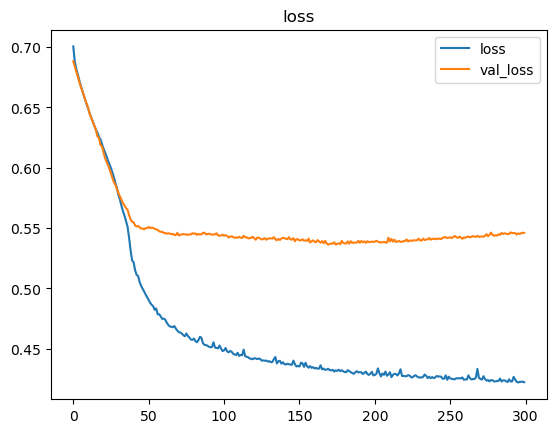

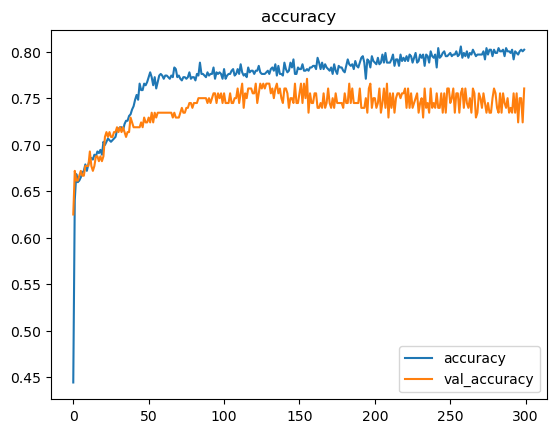

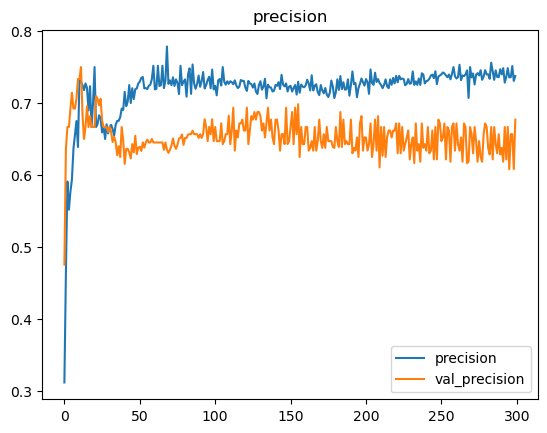

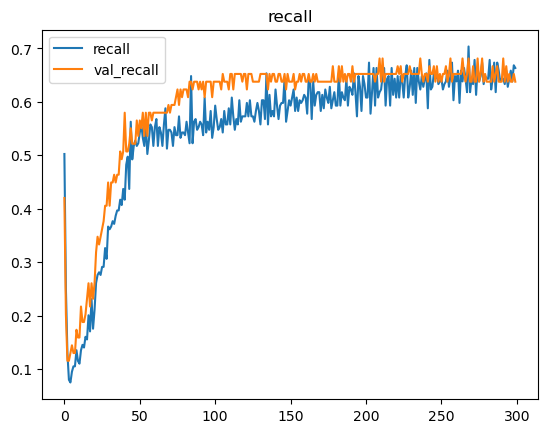

In [16]:
# Visualize Learning History

plot_history(history)

## Evaluation


6/6 [==============================] - 0s 1ms/step
base_model_train 

              precision    recall  f1-score   support

 No Diabetes       0.82      0.89      0.85       377
    Diabetes       0.75      0.62      0.68       199

    accuracy                           0.80       576
   macro avg       0.78      0.76      0.77       576
weighted avg       0.79      0.80      0.79       576



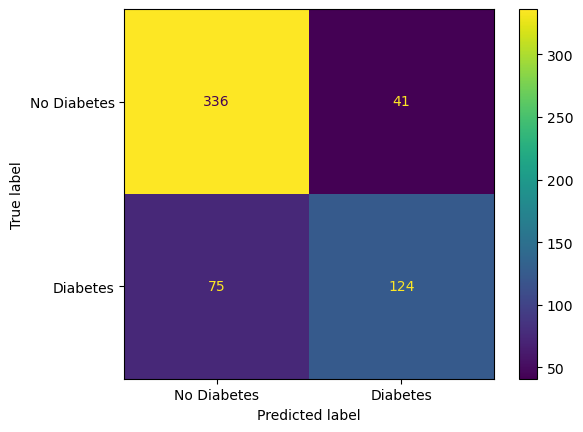

base_model_test 

              precision    recall  f1-score   support

 No Diabetes       0.80      0.83      0.82       123
    Diabetes       0.68      0.64      0.66        69

    accuracy                           0.76       192
   macro avg       0.74      0.73      0.74       192
weighted avg       0.76      0.76      0.76       192



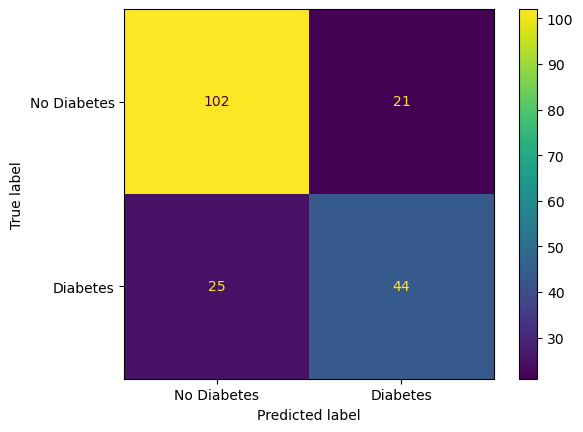

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
base_model_train,0.751515,0.623116,0.681319,0.798611
base_model_test,0.676923,0.637681,0.656716,0.760417


In [17]:
# Get predictions
base_scores = eval_nn_classification(class_model, X_train, y_train, X_test, y_test, model_name='base_model')
base_scores

# <center> Attack Bias or Variance? </center>

How should we tune this classification model?

# Improving ANN - 2nd Model

In [30]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Build your model
class_model2 = Sequential()
class_model2.add(Dense(10, activation= 'relu', input_dim=X_train.shape[1]))
class_model2.add(Dense(5, activation= 'relu'))
class_model2.add(Dense(2, activation= 'relu'))

# One output node with 'sigmoid' activation
class_model2.add(Dense(1, activation='sigmoid'))
class_model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                90        
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________


## Compiling

Compiling the model puts all the pieces together to make it ready to train.  We need to specify:

* **Optimizer:** An Adam optimizer is a favorite and often performs well, it's a good place to start.
  - Other optimizers : Gradient Descent,Stochastic Gradient Descent,Adagrad,RMSProp
* **Loss Function:**   This is the number our model will try to reduce in each epoch.  Since this is a regression model we want our model to minimize the mean squared error.
* **Metrics:** 'mae' or mean absolute error.  We can provide a list of any appropriate metrics we want the model to keep track at each epoch.




In [31]:
# Compile your model.
precision = Precision()
recall = Recall()

class_model2.compile(loss='bce', optimizer='adam', metrics=['acc', precision, recall])


# Training

Let's try training our model for 100 epochs.  Sometimes that is enough, and it will give us an idea whether our model is learning anything.

Epoch 1/300
 1/18 [>.............................] - ETA: 0s - loss: 0.4134 - acc: 0.8438 - precision: 0.8333 - recall: 0.7692

18/18 [==============================] - 0s 5ms/step - loss: 0.4375 - acc: 0.7778 - precision: 0.7178 - recall: 0.5879 - val_loss: 0.5263 - val_acc: 0.7448 - val_precision: 0.6389 - val_recall: 0.6667
Epoch 2/300
18/18 [==============================] - 0s 4ms/step - loss: 0.4394 - acc: 0.7847 - precision: 0.7119 - recall: 0.6332 - val_loss: 0.5286 - val_acc: 0.7188 - val_precision: 0.5926 - val_recall: 0.6957
Epoch 3/300
18/18 [==============================] - 0s 3ms/step - loss: 0.4371 - acc: 0.7865 - precision: 0.7184 - recall: 0.6281 - val_loss: 0.5258 - val_acc: 0.7292 - val_precision: 0.6104 - val_recall: 0.6812
Epoch 4/300
18/18 [==============================] - 0s 3ms/step - loss: 0.4367 - acc: 0.7795 - precision: 0.7143 - recall: 0.6030 - val_loss: 0.5253 - val_acc: 0.7240 - val_precision: 0.6026 - val_recall: 0.6812
Epoch 5/300
18/18 [==============================] - 0s 4ms/step - loss: 0.4362 - acc: 0.7795 - precision: 0.7118 - recall: 0.6080 - val_loss: 0.5249 - val_acc:

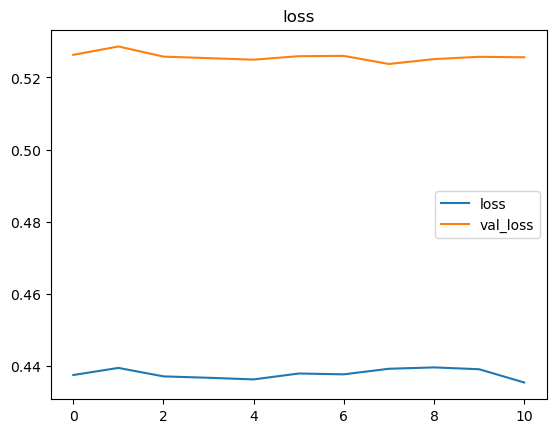

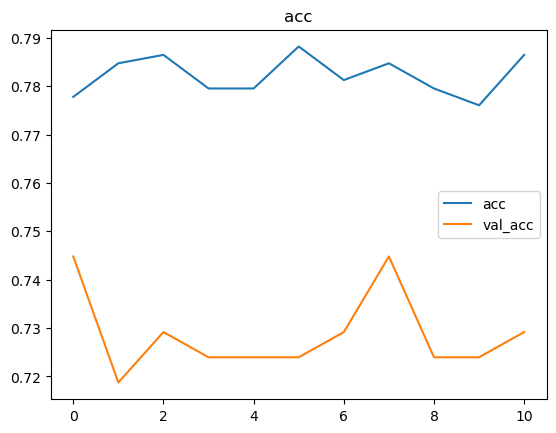

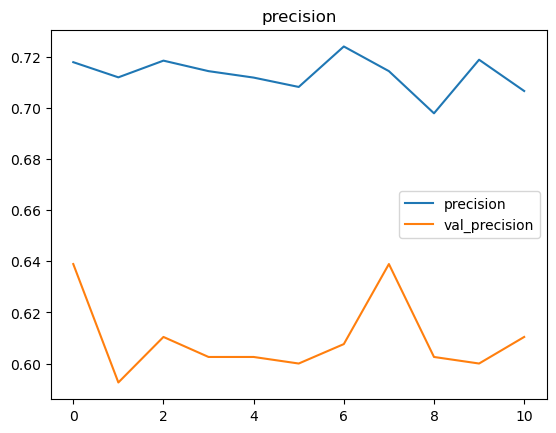

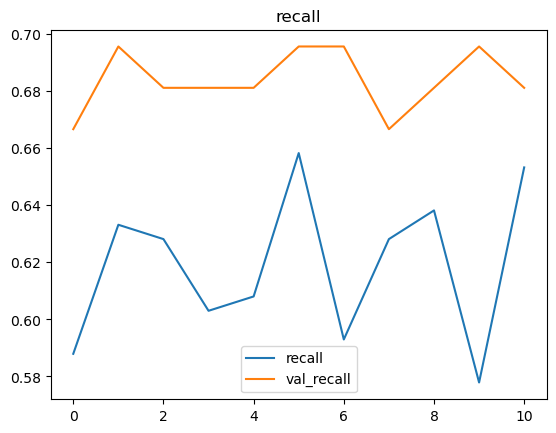

In [34]:
# Fit your model
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=3)

history = class_model2.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=300,
                    callbacks=[early_stop])


plot_history(history)

In [28]:
# Plot Learning History



## Evaluation


 1/18 [>.............................] - ETA: 0s

6/6 [==============================] - 0s 2ms/step
model_2_train 

              precision    recall  f1-score   support

 No Diabetes       0.82      0.87      0.84       377
    Diabetes       0.71      0.63      0.67       199

    accuracy                           0.78       576
   macro avg       0.76      0.75      0.75       576
weighted avg       0.78      0.78      0.78       576



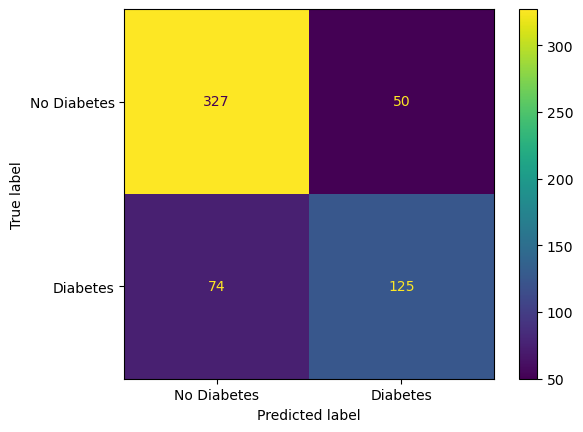

model_2_test 

              precision    recall  f1-score   support

 No Diabetes       0.81      0.76      0.78       123
    Diabetes       0.61      0.68      0.64        69

    accuracy                           0.73       192
   macro avg       0.71      0.72      0.71       192
weighted avg       0.74      0.73      0.73       192



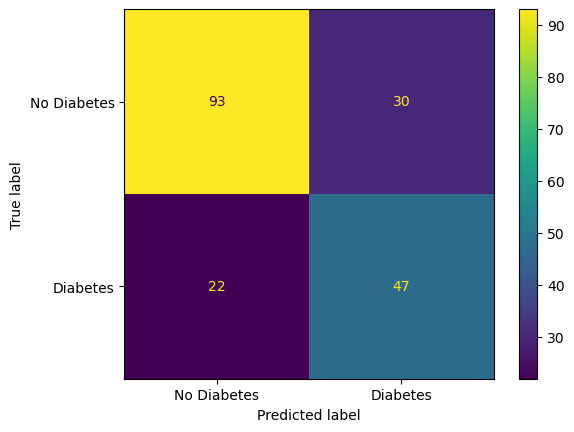

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
base_model_train,0.751515,0.623116,0.681319,0.798611
base_model_test,0.676923,0.637681,0.656716,0.760417
model_2_train,0.714286,0.628141,0.668449,0.784722
model_2_test,0.610390,0.681159,0.643836,0.729167


In [35]:
## Evaluate model

scores_2 = eval_nn_classification(class_model2, X_train, y_train, X_test, y_test, model_name='model_2')
scores = pd.concat([base_scores, scores_2])
scores

# <center> Attack Bias or Variance? </center>

How should we tune this classification model?

# Improving ANN - 3rd Model

In [36]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Build your model
class_model3 = Sequential()
class_model3.add(Dense(10, activation= 'relu', input_dim=X_train.shape[1]))
class_model3.add(Dense(5, activation= 'relu'))
class_model3.add(Dense(5, activation= 'relu'))
class_model3.add(Dense(5, activation= 'relu'))
class_model3.add(Dense(2, activation= 'relu'))

# One output node with 'sigmoid' activation
class_model3.add(Dense(1, activation='sigmoid'))
class_model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                90        
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dense_2 (Dense)             (None, 5)                 30        
                                                                 
 dense_3 (Dense)             (None, 5)                 30        
                                                                 
 dense_4 (Dense)             (None, 2)                 12        
                                                                 
 dense_5 (Dense)             (None, 1)                 3         
                                                                 
Total params: 220
Trainable params: 220
Non-trainable pa

## Compiling

Compiling the model puts all the pieces together to make it ready to train.  We need to specify:

* **Optimizer:** An Adam optimizer is a favorite and often performs well, it's a good place to start.
  - Other optimizers : Gradient Descent,Stochastic Gradient Descent,Adagrad,RMSProp
* **Loss Function:** 'mse' or mean squared error.  This is the number our model will try to reduce in each epoch.  Since this is a regression model we want our model to minimize the mean squared error.
* **Metrics:** 'mae' or mean absolute error.  We can provide a list of any appropriate metrics we want the model to keep track at each epoch.




In [38]:
# Compile your model.
precision = Precision()
recall = Recall()
class_model3.compile(loss='bce', optimizer='adam', metrics=['acc', precision, recall])

# Training

Let's try training our model for 100 epochs.  Sometimes that is enough, and it will give us an idea whether our model is learning anything.

Epoch 1/300
18/18 [==============================] - 1s 17ms/step - loss: 0.6939 - acc: 0.4410 - precision: 0.3324 - recall: 0.6131 - val_loss: 0.6912 - val_acc: 0.6510 - val_precision: 0.5714 - val_recall: 0.1159
Epoch 2/300
18/18 [==============================] - 0s 3ms/step - loss: 0.6898 - acc: 0.6545 - precision: 0.5000 - recall: 0.0251 - val_loss: 0.6888 - val_acc: 0.6406 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/300
18/18 [==============================] - 0s 4ms/step - loss: 0.6872 - acc: 0.6545 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6866 - val_acc: 0.6406 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/300
18/18 [==============================] - 0s 4ms/step - loss: 0.6850 - acc: 0.6545 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6845 - val_acc: 0.6406 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/300
18/18 [==============================] - 0s 5ms/step - loss: 0.6828 - acc: 0.6545 - precision: 

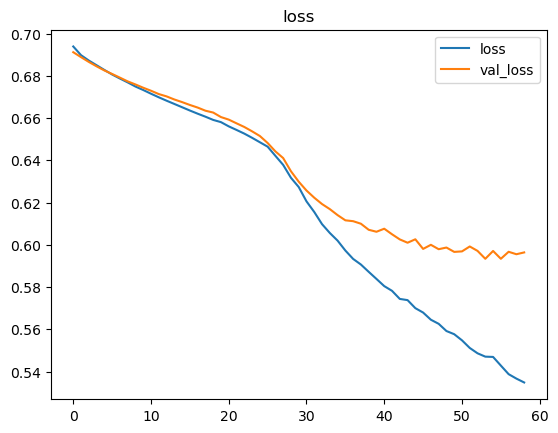

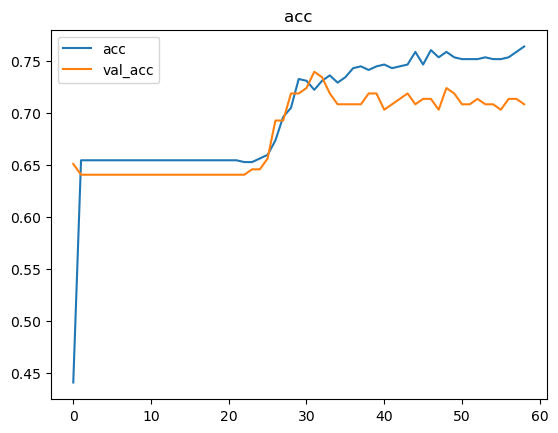

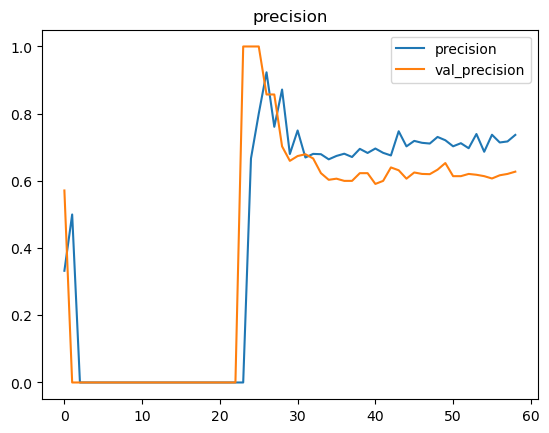

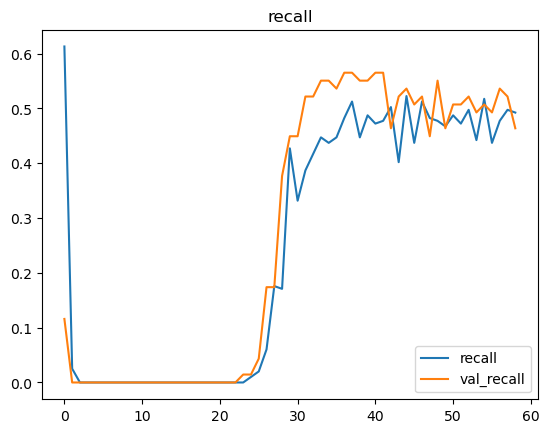

In [39]:
# Fit your model
history = class_model3.fit(X_train, y_train,
                           validation_data=(X_test, y_test),
                           epochs=300,
                           callbacks=[EarlyStopping(patience=5)])

plot_history(history)

In [ ]:
# Apply the custom function to see how your model is doing


## Evaluation


6/6 [==============================] - 0s 1ms/step
model_3_train 

              precision    recall  f1-score   support

 No Diabetes       0.77      0.92      0.84       377
    Diabetes       0.76      0.47      0.58       199

    accuracy                           0.77       576
   macro avg       0.76      0.70      0.71       576
weighted avg       0.77      0.77      0.75       576



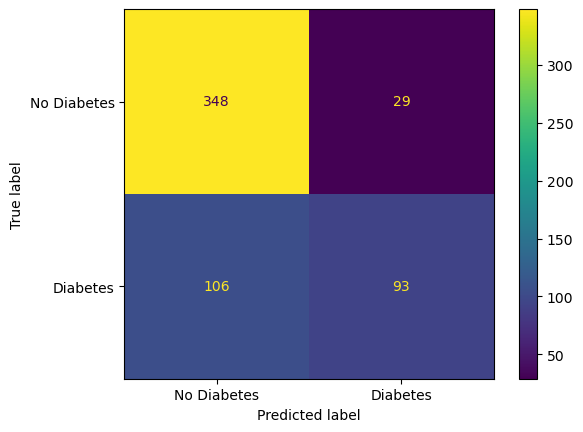

model_3_test 

              precision    recall  f1-score   support

 No Diabetes       0.74      0.85      0.79       123
    Diabetes       0.63      0.46      0.53        69

    accuracy                           0.71       192
   macro avg       0.68      0.65      0.66       192
weighted avg       0.70      0.71      0.70       192



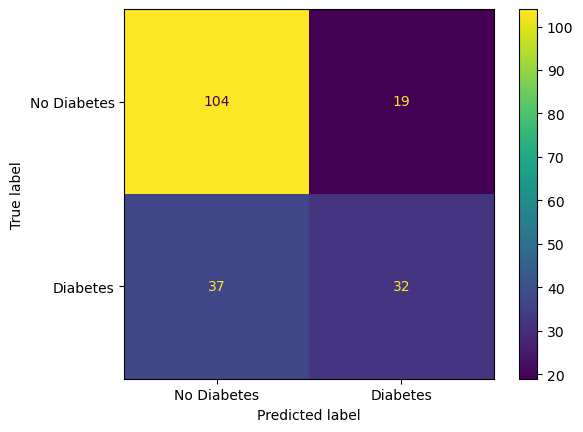

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
base_model_train,0.751515,0.623116,0.681319,0.798611
base_model_test,0.676923,0.637681,0.656716,0.760417
model_2_train,0.714286,0.628141,0.668449,0.784722
model_2_test,0.610390,0.681159,0.643836,0.729167
model_3_train,0.762295,0.467337,0.579439,0.765625
model_3_test,0.627451,0.463768,0.533333,0.708333


In [40]:
## Evaluate model

scores_3 = eval_nn_classification(class_model3, X_train, y_train, X_test, y_test, model_name='model_3')
scores = pd.concat([scores, scores_3])
scores

# <center> Attack Bias or Variance? </center>

How should we tune this classification model?

# Improving ANN - 4th Model

In [58]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
from tensorflow.keras.regularizers import l2, l1, l1_l2
# Build your model
class_model4 = Sequential()
class_model4.add(Dense(100, activation= 'relu', input_dim=X_train.shape[1],
                       kernel_regularizer=l1(1e-3)))
class_model4.add(Dropout(.3))
class_model4.add(Dense(50, activation= 'relu', kernel_regularizer=l1(1e-3)))
class_model4.add(Dropout(.3))
class_model4.add(Dense(50, activation= 'relu', kernel_regularizer=l1(1e-3)))
class_model4.add(Dropout(.3))
class_model4.add(Dense(50, activation= 'relu', kernel_regularizer=l1(1e-3)))
class_model4.add(Dropout(.3))
class_model4.add(Dense(20, activation= 'relu', kernel_regularizer=l1(1e-3)))
class_model4.add(Dropout(.3))
# One output node with 'sigmoid' activation
class_model4.add(Dense(1, activation='sigmoid'))
class_model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               900       
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 50)                2

## Compiling

Compiling the model puts all the pieces together to make it ready to train.  We need to specify:

* **Optimizer:** An Adam optimizer is a favorite and often performs well, it's a good place to start.
  - Other optimizers : Gradient Descent,Stochastic Gradient Descent,Adagrad,RMSProp
* **Loss Function:** 'mse' or mean squared error.  This is the number our model will try to reduce in each epoch.  Since this is a regression model we want our model to minimize the mean squared error.
* **Metrics:** 'mae' or mean absolute error.  We can provide a list of any appropriate metrics we want the model to keep track at each epoch.




In [59]:
# Compile your model.
precision = Precision()
recall = Recall()

class_model4.compile(optimizer= 'adam', loss = 'bce', metrics= ['acc', precision, recall])

# Training

Let's try training our model for 100 epochs and add EarlyStopping.

In [60]:
from tensorflow.keras.callbacks import EarlyStopping

Epoch 1/300


18/18 [==============================] - 1s 19ms/step - loss: 1.9733 - acc: 0.6076 - precision: 0.3884 - recall: 0.2362 - val_loss: 1.8803 - val_acc: 0.6406 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/300
18/18 [==============================] - 0s 3ms/step - loss: 1.8038 - acc: 0.6580 - precision: 0.5833 - recall: 0.0352 - val_loss: 1.7217 - val_acc: 0.6406 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/300
18/18 [==============================] - 0s 3ms/step - loss: 1.6560 - acc: 0.6545 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.5802 - val_acc: 0.6406 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/300
18/18 [==============================] - 0s 3ms/step - loss: 1.5202 - acc: 0.6545 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4497 - val_acc: 0.6406 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/300
18/18 [==============================] - 0s 3ms/step - loss: 1.3960 - acc: 0.6545 - precision: 0.00

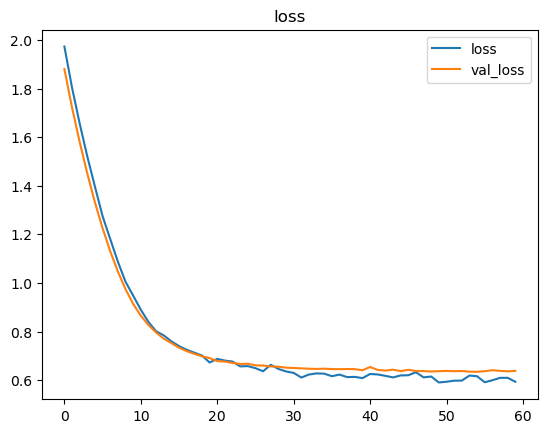

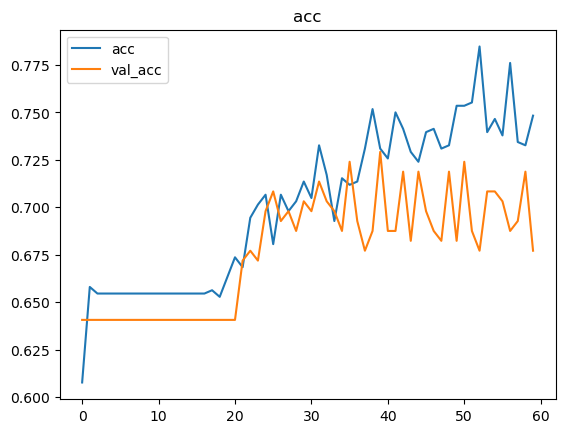

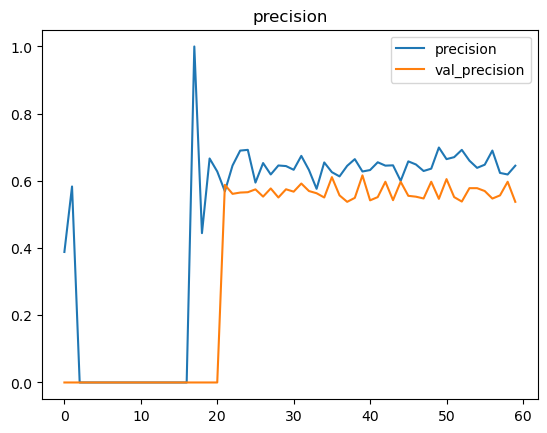

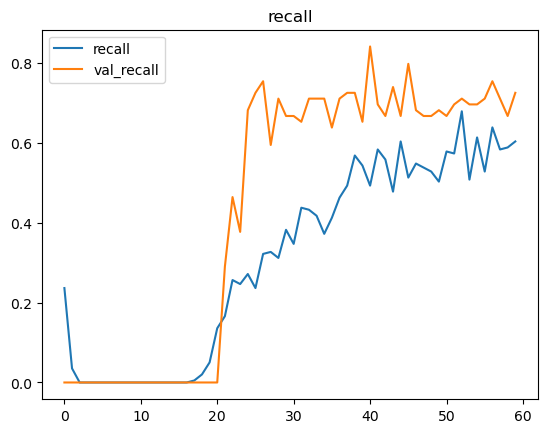

In [61]:
# Fit your model
history = class_model4.fit(X_train, y_train,
                           validation_data=(X_test, y_test),
                           epochs=300, 
                           callbacks=[EarlyStopping(patience=5)])
#Early Stopping?
# Fit Model
plot_history(history)

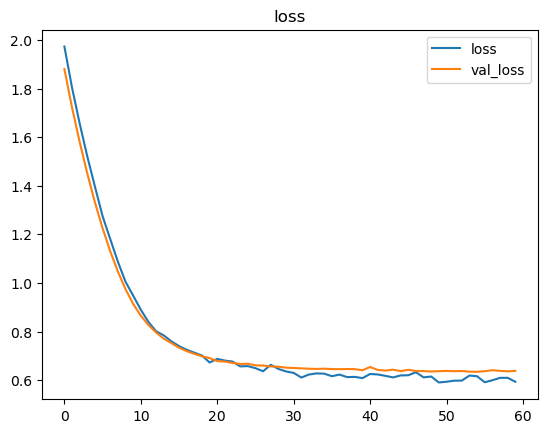

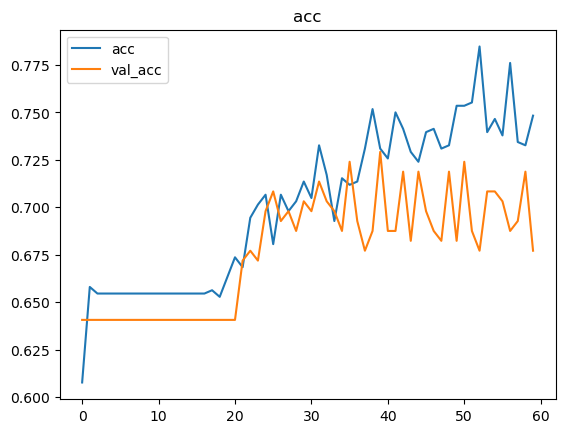

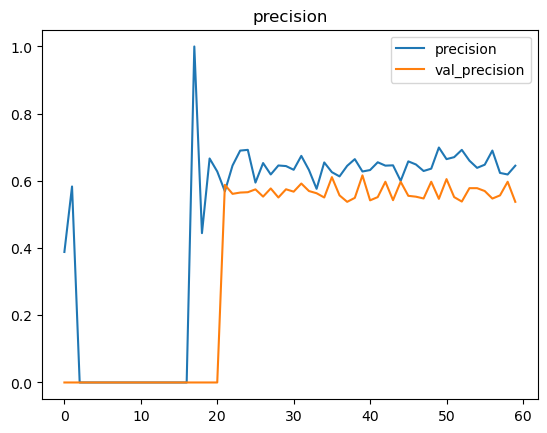

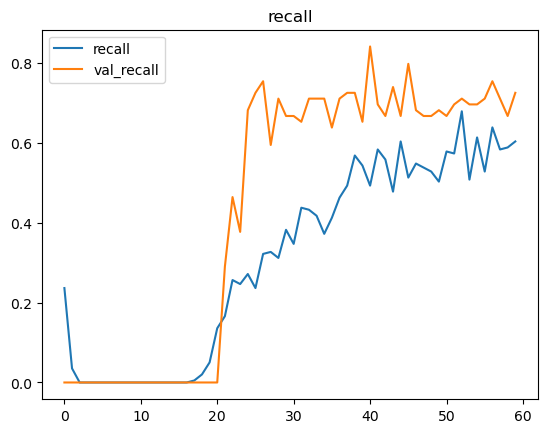

In [62]:
# Apply the custom function to see how your model is doing
plot_history(history)

## Evaluation


6/6 [==============================] - 0s 1ms/step
model_2_train 

              precision    recall  f1-score   support

 No Diabetes       0.84      0.80      0.82       377
    Diabetes       0.65      0.72      0.68       199

    accuracy                           0.77       576
   macro avg       0.75      0.76      0.75       576
weighted avg       0.78      0.77      0.77       576



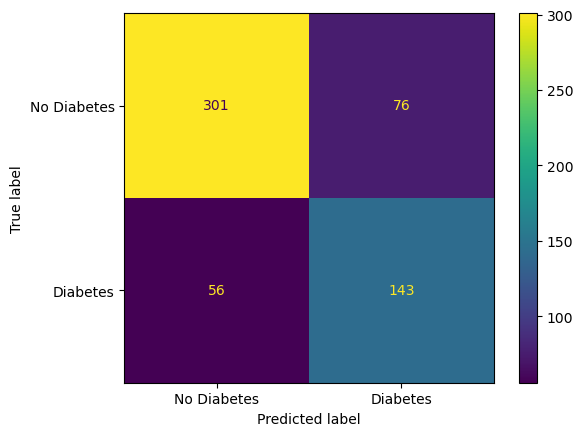

model_2_test 

              precision    recall  f1-score   support

 No Diabetes       0.81      0.65      0.72       123
    Diabetes       0.54      0.72      0.62        69

    accuracy                           0.68       192
   macro avg       0.67      0.69      0.67       192
weighted avg       0.71      0.68      0.68       192



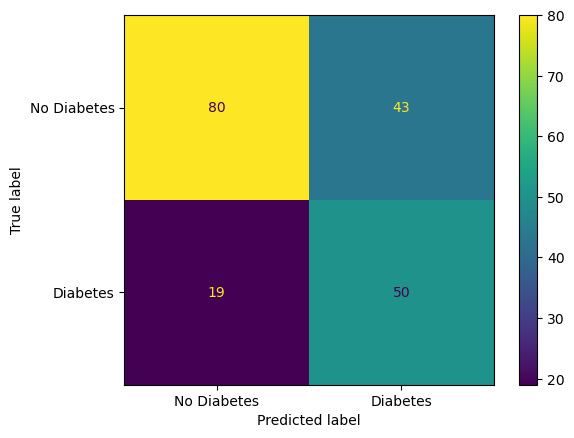

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
base_model_train,0.751515,0.623116,0.681319,0.798611
base_model_test,0.676923,0.637681,0.656716,0.760417
model_2_train,0.714286,0.628141,0.668449,0.784722
model_2_test,0.610390,0.681159,0.643836,0.729167
model_3_train,0.762295,0.467337,0.579439,0.765625
model_3_test,0.627451,0.463768,0.533333,0.708333
model_2_train,0.730061,0.597990,0.657459,0.784722
model_2_test,0.671875,0.623188,0.646617,0.755208
model_2_train,0.668421,0.638191,0.652956,0.765625


In [63]:
## Evaluate model

scores_4 = eval_nn_classification(class_model4, X_train, y_train, X_test, y_test, model_name='model_2')
scores = pd.concat([scores, scores_4])
scores

## Choose a model

Which model performed best?